<a href="https://colab.research.google.com/github/samsomsabu/Student-Attendance-Analysis-and-Insights/blob/main/Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<ipython-input-1-beee91e61502>:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  absences['Month'] = absences['Date'].dt.month  # Add Month to absences explicitly


Seasonal Absence Trends:
 Month
1    1811
2    1728
3    1891
dtype: int64
Top Morning Skippers:
 Student_ID
13    49
5     45
15    44
34    44
18    43
6     43
21    42
31    42
50    41
12    41
Name: Present, dtype: int64
Top Last Hour Skippers:
 Student_ID
5     27
23    26
43    26
48    25
19    25
36    24
10    24
21    23
15    22
13    22
Name: Present, dtype: int64
Day-wise Absence Count:
 Weekday
Monday       796
Thursday     787
Sunday       784
Tuesday      784
Friday       777
Wednesday    760
Saturday     742
Name: Present, dtype: int64
Repeated Leaves:
       Student_ID       Date  Count
2              1 2024-01-03      2
8              1 2024-01-09      2
10             1 2024-01-12      4
12             1 2024-01-15      2
13             1 2024-01-17      2
...          ...        ...    ...
3309          50 2024-03-13      2
3314          50 2024-03-20      2
3315          50 2024-03-21      3
3316          50 2024-03-22      4
3322          50 2024-03-29      2



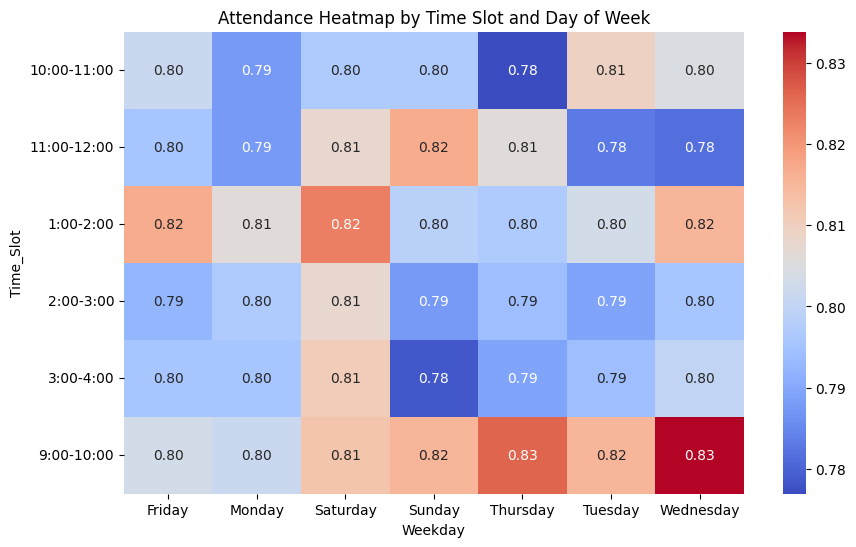

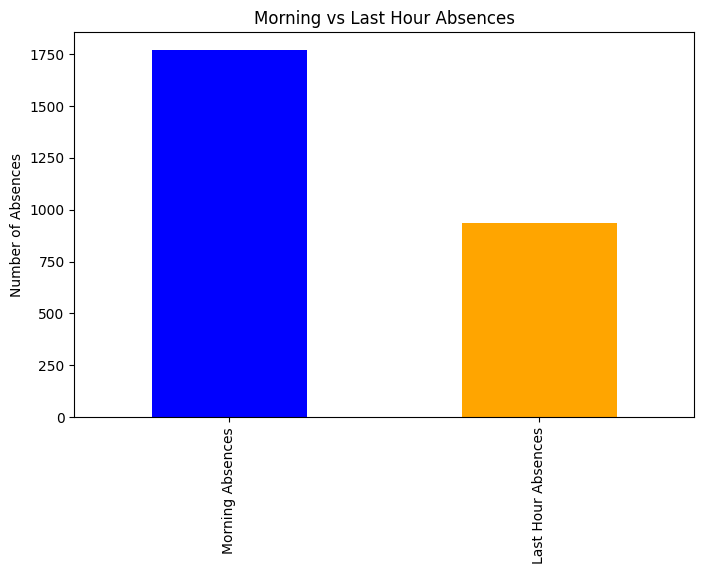

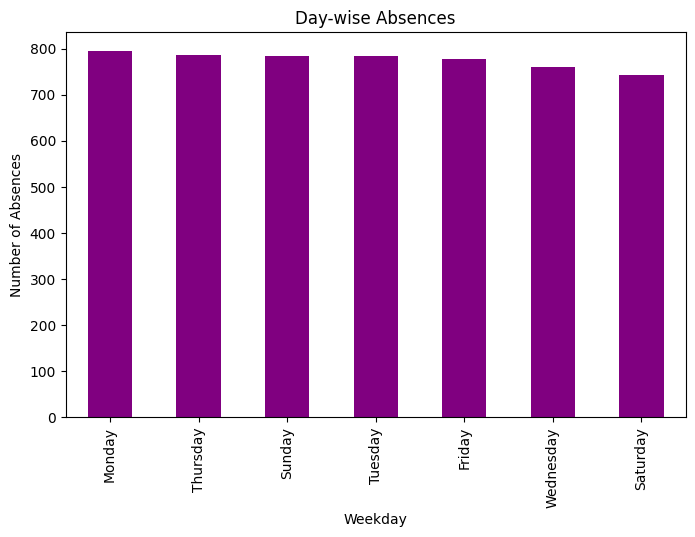

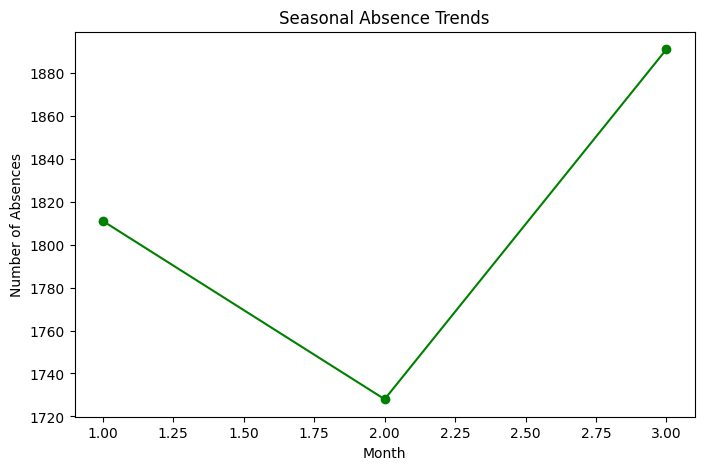

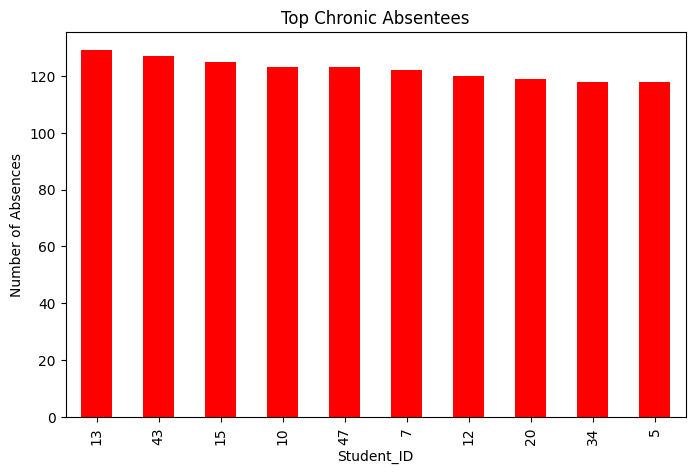

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime

# Load Dataset
file_path = "/content/student_attendance_dataset.csv"  # Update with your file path if necessary
attendance_df = pd.read_csv(file_path)

# Convert Date to datetime
attendance_df['Date'] = pd.to_datetime(attendance_df['Date'])
attendance_df['Weekday'] = attendance_df['Date'].dt.day_name()

# Feature Engineering: Time-Slot Indicators
attendance_df['Is_Morning'] = attendance_df['Time_Slot'].apply(lambda x: 1 if x in ["9:00-10:00", "10:00-11:00"] else 0)
attendance_df['Is_Last_Hour'] = attendance_df['Time_Slot'].apply(lambda x: 1 if x == "3:00-4:00" else 0)

# Adding Month to the main dataframe
attendance_df['Month'] = attendance_df['Date'].dt.month

# Filtering absences and ensuring the Month column is retained
absences = attendance_df[attendance_df['Present'] == 0]
absences['Month'] = absences['Date'].dt.month  # Add Month to absences explicitly

# Grouping by Month to find seasonal absence trends
monthly_absences = absences.groupby('Month').size()
print("Seasonal Absence Trends:\n", monthly_absences)

# --- PATTERN ANALYSIS --- #

# 1. Morning Hour Skipping
morning_absences = absences[absences['Is_Morning'] == 1].groupby('Student_ID')['Present'].count()
print("Top Morning Skippers:\n", morning_absences.sort_values(ascending=False).head(10))

# 2. Last Hour Skipping
last_hour_absences = absences[absences['Is_Last_Hour'] == 1].groupby('Student_ID')['Present'].count()
print("Top Last Hour Skippers:\n", last_hour_absences.sort_values(ascending=False).head(10))

# 3. Skipping Specific Days
weekday_absences = absences.groupby('Weekday')['Present'].count().sort_values(ascending=False)
print("Day-wise Absence Count:\n", weekday_absences)

# 4. Repeated Leaves
repeated_absences = absences.groupby(['Student_ID', 'Date']).size().reset_index(name='Count')
repeated_leaves = repeated_absences[repeated_absences['Count'] > 1]
print("Repeated Leaves:\n", repeated_leaves)

# 5. Holiday Adjacent Leaves (requires a holiday dataset, here we simulate)
# Correcting the Holiday Adjacent Leaves Calculation
holidays = pd.to_datetime(['2024-01-26', '2024-03-08'])  # Example holidays as datetime
attendance_df['Is_Holiday_Adjacent'] = attendance_df['Date'].apply(
    lambda x: any((x - holiday).days in [-1, 1] for holiday in holidays)
).astype(int)

# Filter Holiday Adjacent Absences
holiday_absences = attendance_df[(attendance_df['Is_Holiday_Adjacent'] == 1) & (attendance_df['Present'] == 0)]
print("Holiday Adjacent Absences:\n", holiday_absences)


# 6. Chronic Absentees
chronic_absentees = absences.groupby('Student_ID')['Present'].count().sort_values(ascending=False).head(10)
print("Top Chronic Absentees:\n", chronic_absentees)

# 7. Time-Slot Preference
time_slot_preferences = attendance_df.groupby(['Time_Slot'])['Present'].mean().sort_values(ascending=False)
print("Time Slot Attendance Rate:\n", time_slot_preferences)

# 8. Seasonal Trends
attendance_df['Month'] = attendance_df['Date'].dt.month
monthly_absences = absences.groupby('Month')['Present'].count()
print("Seasonal Absence Trends:\n", monthly_absences)

# 9. Streak Analysis
streaks = absences.groupby('Student_ID')['Date'].apply(lambda x: x.diff().dt.days.fillna(1).tolist())
streak_summary = {student: sum(1 for _ in group if _ == 1) for student, group in streaks.items()}
print("Streak Summary:\n", streak_summary)

# --- VISUALIZATION --- #

# 1. Heatmap for Attendance Trends
attendance_pivot = attendance_df.pivot_table(index='Time_Slot', columns='Weekday', values='Present', aggfunc='mean')
plt.figure(figsize=(10, 6))
sns.heatmap(attendance_pivot, annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Attendance Heatmap by Time Slot and Day of Week")
plt.show()

# 2. Morning vs Last Hour Absences
plt.figure(figsize=(8, 5))
morning_last_hour_data = pd.DataFrame({
    'Morning Absences': morning_absences,
    'Last Hour Absences': last_hour_absences
}).fillna(0).sum()
morning_last_hour_data.plot(kind='bar', color=['blue', 'orange'])
plt.title("Morning vs Last Hour Absences")
plt.ylabel("Number of Absences")
plt.show()

# 3. Day-wise Absences
plt.figure(figsize=(8, 5))
weekday_absences.plot(kind='bar', color='purple')
plt.title("Day-wise Absences")
plt.ylabel("Number of Absences")
plt.show()

# 4. Seasonal Trends
plt.figure(figsize=(8, 5))
monthly_absences.plot(kind='line', marker='o', color='green')
plt.title("Seasonal Absence Trends")
plt.ylabel("Number of Absences")
plt.xlabel("Month")
plt.show()

# 5. Top Chronic Absentees
plt.figure(figsize=(8, 5))
chronic_absentees.plot(kind='bar', color='red')
plt.title("Top Chronic Absentees")
plt.ylabel("Number of Absences")
plt.show()


In [ ]:
# Calculate Top Morning Skippers
morning_absences = attendance_df[(attendance_df['Is_Morning'] == 1) & (attendance_df['Present'] == 0)]
top_morning_skippers = morning_absences.groupby('Student_ID').size().sort_values(ascending=False).head(10)

# Display for verification
print("Top Morning Skippers:\n", top_morning_skippers)

# Calculate Top Last Hour Skippers
last_hour_absences = attendance_df[(attendance_df['Is_Last_Hour'] == 1) & (attendance_df['Present'] == 0)]
top_last_hour_skippers = last_hour_absences.groupby('Student_ID').size().sort_values(ascending=False).head(10)

# Display for verification
print("Top Last Hour Skippers:\n", top_last_hour_skippers)


Top Morning Skippers:
 Student_ID
13    49
5     45
15    44
34    44
18    43
6     43
21    42
31    42
50    41
12    41
dtype: int64
Top Last Hour Skippers:
 Student_ID
5     27
23    26
43    26
48    25
19    25
36    24
10    24
21    23
15    22
13    22
dtype: int64


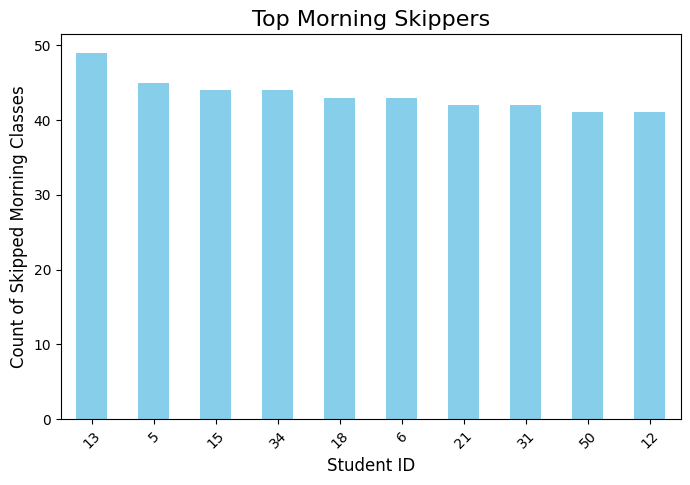

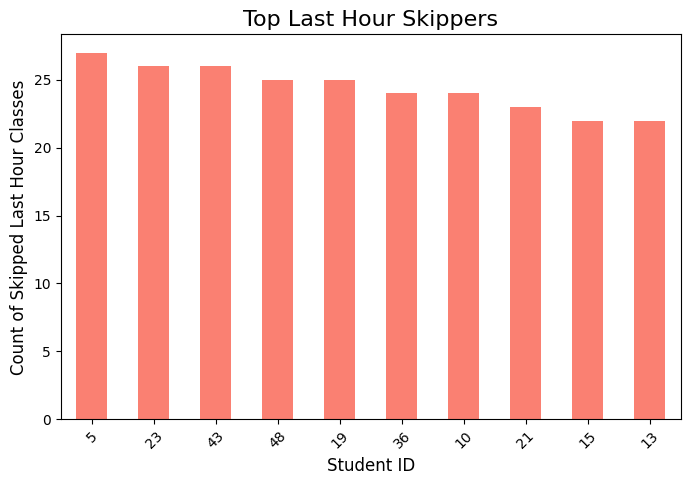

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Top Morning Skippers Visualization
top_morning_skippers.plot(kind='bar', color='skyblue', figsize=(8, 5))
plt.title("Top Morning Skippers", fontsize=16)
plt.xlabel("Student ID", fontsize=12)
plt.ylabel("Count of Skipped Morning Classes", fontsize=12)
plt.xticks(rotation=45)
plt.show()

# Top Last Hour Skippers Visualization
top_last_hour_skippers.plot(kind='bar', color='salmon', figsize=(8, 5))
plt.title("Top Last Hour Skippers", fontsize=16)
plt.xlabel("Student ID", fontsize=12)
plt.ylabel("Count of Skipped Last Hour Classes", fontsize=12)
plt.xticks(rotation=45)
plt.show()


In [ ]:
# Calculate Day-Wise Absence Count
day_wise_absences = attendance_df[attendance_df['Present'] == 0].groupby('Weekday').size()

# Display for verification
print("Day-wise Absence Count:\n", day_wise_absences)


Day-wise Absence Count:
 Weekday
Friday       777
Monday       796
Saturday     742
Sunday       784
Thursday     787
Tuesday      784
Wednesday    760
dtype: int64


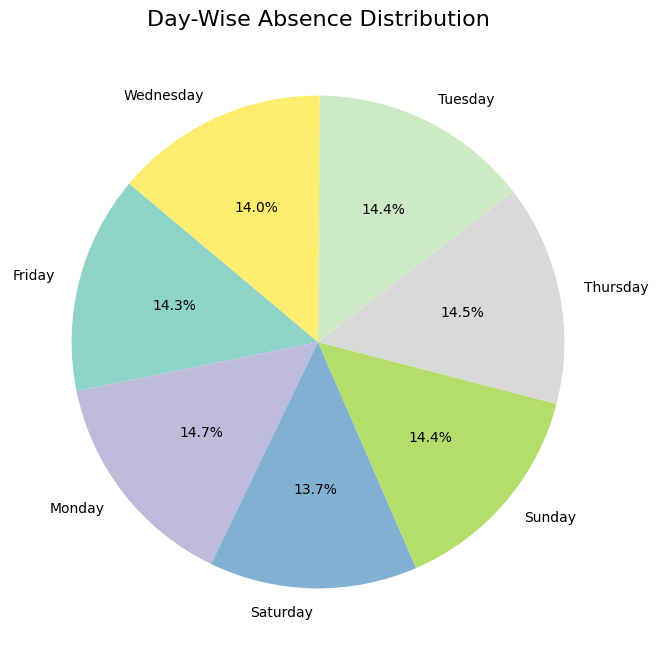

In [ ]:
# Day-Wise Absence Count Visualization
day_wise_absences.plot(kind='pie', autopct='%1.1f%%', startangle=140, figsize=(8, 8), colormap='Set3')
plt.title("Day-Wise Absence Distribution", fontsize=16)
plt.ylabel("")  # Hide y-label
plt.show()


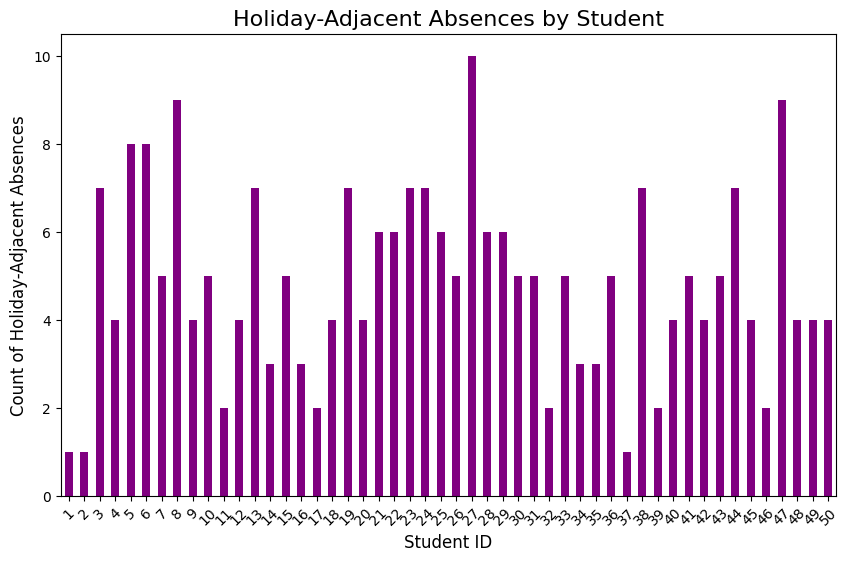

In [ ]:
holiday_adjacent_absences = holiday_absences.groupby('Student_ID').size()

# Visualization
holiday_adjacent_absences.plot(kind='bar', color='purple', figsize=(10, 6))
plt.title("Holiday-Adjacent Absences by Student", fontsize=16)
plt.xlabel("Student ID", fontsize=12)
plt.ylabel("Count of Holiday-Adjacent Absences", fontsize=12)
plt.xticks(rotation=45)
plt.show()


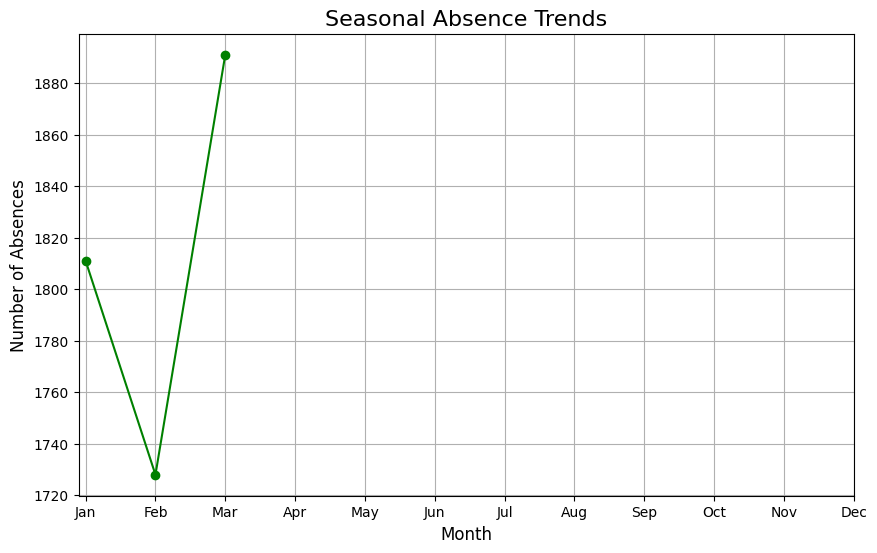

In [ ]:
# Seasonal Trends Visualization
monthly_absences.plot(kind='line', marker='o', color='green', figsize=(10, 6))
plt.title("Seasonal Absence Trends", fontsize=16)
plt.xlabel("Month", fontsize=12)
plt.ylabel("Number of Absences", fontsize=12)
plt.xticks(ticks=range(1, 13), labels=['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun',
                                       'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'])
plt.grid()
plt.show()


In [ ]:
# Calculate Time Slot Attendance Rate
time_slot_attendance_rate = attendance_df.groupby('Time_Slot')['Present'].mean()

# Display for verification
print("Time Slot Attendance Rate:\n", time_slot_attendance_rate)


Time Slot Attendance Rate:
 Time_Slot
10:00-11:00    0.796264
11:00-12:00    0.796923
1:00-2:00      0.808571
2:00-3:00      0.794725
3:00-4:00      0.794725
9:00-10:00     0.815385
Name: Present, dtype: float64


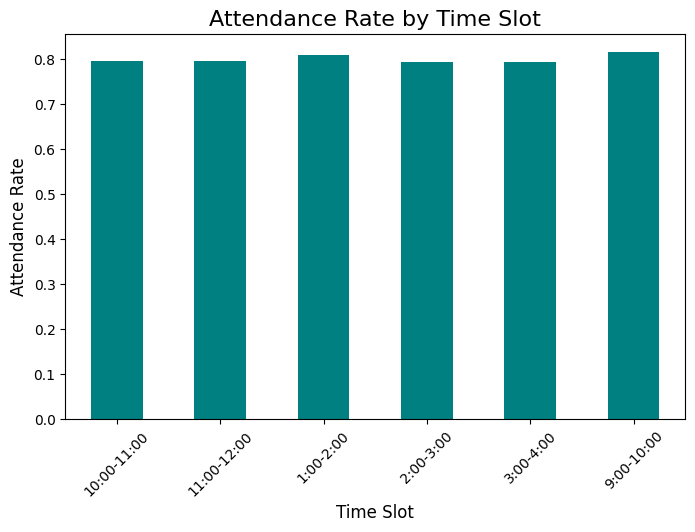

In [ ]:
# Time Slot Attendance Rate Visualization
time_slot_attendance_rate.plot(kind='bar', color='teal', figsize=(8, 5))
plt.title("Attendance Rate by Time Slot", fontsize=16)
plt.xlabel("Time Slot", fontsize=12)
plt.ylabel("Attendance Rate", fontsize=12)
plt.xticks(rotation=45)
plt.show()


In [ ]:
# Calculate Top Chronic Absentees
chronic_absentees = attendance_df[attendance_df['Present'] == 0]
top_chronic_absentees = chronic_absentees.groupby('Student_ID').size().sort_values(ascending=False).head(10)

# Display for verification
print("Top Chronic Absentees:\n", top_chronic_absentees)


Top Chronic Absentees:
 Student_ID
13    129
43    127
15    125
10    123
47    123
7     122
12    120
20    119
34    118
5     118
dtype: int64


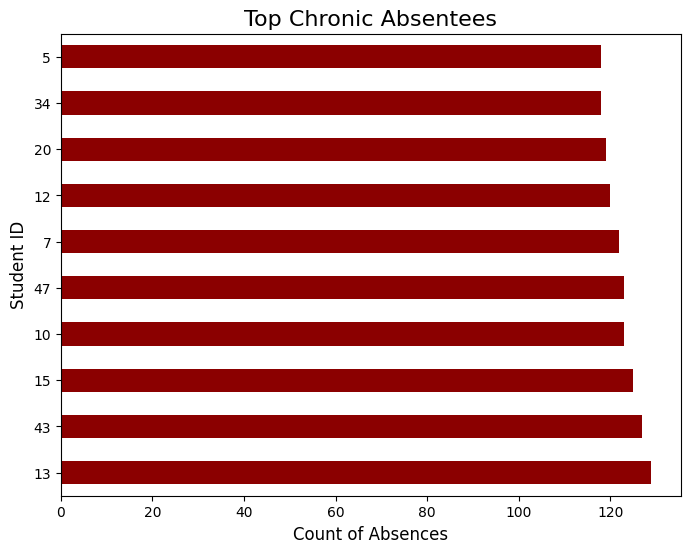

In [ ]:
# Chronic Absentees Visualization
top_chronic_absentees.plot(kind='barh', color='darkred', figsize=(8, 6))
plt.title("Top Chronic Absentees", fontsize=16)
plt.xlabel("Count of Absences", fontsize=12)
plt.ylabel("Student ID", fontsize=12)
plt.show()


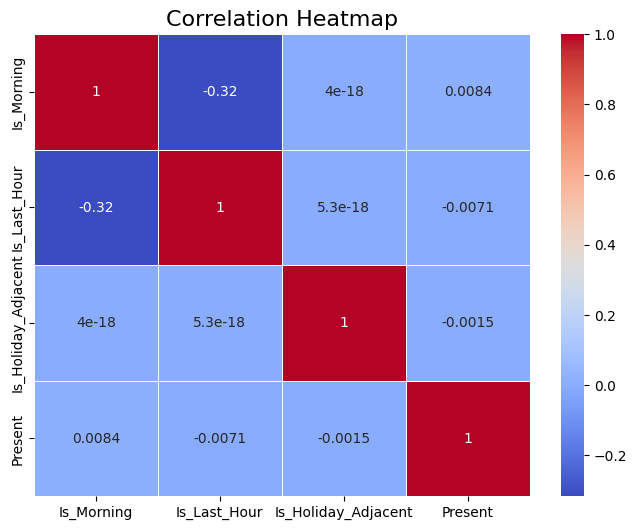

In [ ]:
# Prepare Data for Correlation
correlation_data = attendance_df[['Is_Morning', 'Is_Last_Hour', 'Is_Holiday_Adjacent', 'Present']]
correlation_matrix = correlation_data.corr()

# Plot Heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', linewidths=0.5)
plt.title("Correlation Heatmap", fontsize=16)
plt.show()


#Insights gained:

**1. Seasonal Trends:**  The analysis reveals monthly variations in absences, indicating potential seasonal influences on student attendance.  This could be due to factors like weather, holidays, or exam periods.

**2. Time-of-Day Patterns:**  Students are more likely to skip classes during specific time slots, particularly in the mornings and the last hour of the day.  The code identifies the "top morning skippers" and "top last hour skippers," suggesting potential scheduling conflicts or student fatigue.

**3. Day-of-Week Patterns:** Some days of the week see significantly more absences than others, indicating potential underlying factors like extracurricular activities or weekend effects that carry over to Monday.

**4. Repeated Absences:** The code highlights students with multiple absences on the same day, suggesting possible illness, emergencies, or other recurring issues.

**5. Holiday Effect:** The analysis looks for absences around holidays, identifying students who tend to skip classes before or after holiday breaks.

**6. Chronic Absenteeism:**  The code identifies the students with the highest overall absence rates ("top chronic absentees").  These students warrant further investigation to understand the root causes of their absenteeism.

**7. Time Slot Preferences:**  Some time slots have higher or lower average attendance rates, indicating potential preferences or difficulties with certain classes or schedules.

**8. Streak Analysis:** The code attempts to analyze consecutive days of absence for each student. This could highlight periods of extended absence that may require intervention.

**Visualizations:** The code uses various visualizations (heatmaps, bar charts, line plots, pie charts) to effectively communicate these insights.  For example:

* **Heatmaps:** Show the relationship between time slots and days of the week with respect to attendance.
* **Bar charts:**  Illustrate the frequency of absences for different categories (e.g., top skippers, day-wise absences).
* **Line plots:** Display seasonal trends in absences.


**Overall:** The code provides a comprehensive overview of student attendance patterns, highlighting potential areas of concern and offering data-driven insights that can inform interventions to improve student attendance and engagement.  The visualizations enhance the interpretability and impact of the findings.
